In [80]:
import io
import os.path
import random

import h5py
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchmetrics import ConfusionMatrix, Accuracy, F1Score


torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)


## AUC评分计算

In [81]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float=0.80) -> float:

    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)

    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc, fpr, tpr

In [82]:
def data_split(data_path_):
    datas = pd.read_csv(os.path.join(data_path_, 'train-metadata.csv'),
                        usecols=['isic_id', 'target'])

    groups = datas.groupby('target')
    positive_sample_ = datas.iloc[list(groups.groups[1])]
    data = datas['isic_id'].values
    target = datas['target'].values

    train_data_, train_target_, test_data_, test_target_ = train_test_split(data, target,
                                                                            test_size=0.01, random_state=50)
    return train_data_, train_target_, test_data_, test_target_, positive_sample_

## Dateset构建

In [83]:
class SkinCancerDataset(Dataset):
    def __init__(self, data_, target_, metadata_, positive_sample_, img_data_, standard_, ratio=-0.1):
        super(SkinCancerDataset, self).__init__()
        self.data = data_
        self.target = target_
        self.metadata = metadata_,
        self.positive_sample = positive_sample_
        self.img_data = img_data_
        self.standard = standard_
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(),
            transforms.Resize(size=(128, 128), antialias=True),
        ])
        self.ratio = ratio

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 随机生成一个正样本数据替换原样本
        random_num = random.randint(0, len(self.positive_sample)-1)
        if random_num % self.ratio == 0:
            random_pos_sample = self.positive_sample.iloc[random_num]
            isic_id_ = random_pos_sample['isic_id']
            y = random_pos_sample['target']
        else:
            isic_id_ = self.data[index]
            y = self.target[index]
        img = Image.open(io.BytesIO(self.img_data[isic_id_][...]))
        img = np.array(img)
        img = self.transform(img)

        meta = pd.DataFrame(self.metadata[0].loc[isic_id_].values.reshape(1, -1), columns=use_cols[1:])
        meta = self.standard.transform(meta).reshape(-1)

        return img.numpy(), meta, y

## 训练器

In [84]:
class Trainer:
    def __init__(self, model: nn.Module, loss_fn_, optim, train_dataloader_, test_dataloader_,
                 save_model_dir, total_epoch, accuracy, f1_score, metric,
                 device='cuda', early_stop=True, early_stop_epoch=5,
                 ):
        self.model = model
        self.loss_fn = loss_fn_
        self.optim = optim
        self.train_dataloader = train_dataloader_
        self.test_dataloader = test_dataloader_
        self.total_epoch = total_epoch
        self.save_model_dir = save_model_dir
        self.early_stop = early_stop
        self.early_stop_epoch = early_stop_epoch
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.best_accuracy = 0
        self.best_auc_score = 0
        self.best_f1_score = 0
        self.accuracy = accuracy
        self.f1_score = f1_score
        self.metric = metric
        self.begin_epoch = 0
        self.scheduler = lr_scheduler.LinearLR(self.optim,
                                               start_factor=1.0, end_factor=0.01, total_iters=10)

        # 模型代码恢复
        best_model_name = 'best_auc_score.pkl'
        model_names = os.listdir(self.save_model_dir)
        model_path = None
        if best_model_name in model_names:
            model_path = os.path.join(self.save_model_dir, best_model_name)

        if model_path is not None and os.path.exists(model_path):
            print(f"开始进行模型参数恢复:{model_path}")
            save_data = torch.load(model_path, map_location=torch.device('cpu'))
            best_param = save_data['net_state_dict']
            self.begin_epoch = save_data['epoch'] + 1
            self.total_epoch += self.begin_epoch
            self.best_accuracy = save_data.get('best_accuracy', self.best_accuracy)
            self.best_auc_score = save_data.get('best_auc_score', self.best_auc_score)
            self.best_f1_score = save_data.get('best_f1_score', self.best_f1_score)

            missing_keys, unexpected_keys = self.model.load_state_dict(best_param, strict=False)
            print(f"未进行参数恢复的参数列表为:{missing_keys}")
            print(f"额外给定的参数列表为:{unexpected_keys}")
            print(f'best_accuracy: {self.best_accuracy}')
            print(f'best_f1_score: {self.best_f1_score}')
            print(f'best_auc_score: {self.best_auc_score}')

    def fit(self):
        counts = 0
        fpr_tpr_list = []
        auc_scores = []
        for epoch in range(self.begin_epoch, self.total_epoch):
            self.train(epoch)
            counts += 1
            accuracy_score, f1_score_, (auc_score, fpr, tpr) = self.eval(epoch)
            self.scheduler.step()

            if accuracy_score >= self.best_accuracy:
                self.best_accuracy = accuracy_score
                self.save_model(epoch, 'best_accuracy', accuracy_score, f1_score_, auc_score)

            if f1_score_ >= self.best_f1_score:
                self.best_f1_score = f1_score_
                self.save_model(epoch, 'best_f1_score', accuracy_score, f1_score_, auc_score)
                counts = 0

            if auc_score >= self.best_auc_score:
                self.best_auc_score = auc_score
                self.save_model(epoch, 'best_auc_score', accuracy_score, f1_score_, auc_score)
                counts = 0

            auc_scores.append(auc_score)
            fpr_tpr_list.append((epoch, fpr, tpr))
            self.save_model(epoch, 'last', accuracy_score, f1_score_, auc_score)
            self.scheduler.step()
            if self.early_stop and counts == self.early_stop_epoch:
                break
        return fpr_tpr_list, auc_scores

    def train(self, epoch):
        self.model.train()
        self.model.to(self.device)

        for idx, ((img_, meta_), y) in enumerate(self.train_dataloader):
            img_, meta_, y = img_.to(self.device), meta_.to(self.device), y.to(self.device)

            output = self.model(img_, meta_)
            self.optim.zero_grad()
            loss = self.loss_fn(output, y)
            loss.backward()
            self.optim.step()

            if (idx + 1) % 100 == 0:
                print(f'{epoch}/{self.total_epoch} {100.0 * idx / len(self.train_dataloader):.2f}% '
                      f'loss: {loss.item()}')

    def eval(self, epoch):
        self.model.eval().to(self.device)
        pred_list = []
        Y = []
        pred_proba = []
        with torch.no_grad():
            for (img_, meta_), y in self.test_dataloader:
                img_, meta_, y = img_.to(self.device), meta_.to(self.device), y.to(self.device)
                output = self.model(img_, meta_)
                proba = torch.softmax(output, dim=1)
                pred = torch.argmax(output, dim=1)
                pred_list.append(pred)
                Y.append(y)
                pred_proba.append(proba[:, 1])

        pred = torch.concat(pred_list, dim=0)
        y = torch.concat(Y, dim=0)
        accuracy_score = self.accuracy(pred.cpu(), y.cpu()).item()
        f1_score_ = self.f1_score(pred.cpu(), y.cpu()).item()

        # AUC计算
        pred_proba = torch.concat(pred_proba, dim=0)
        auc_score, fpr, tpr = score(pd.DataFrame(y.cpu()), pd.DataFrame(pred_proba.cpu()))

        print(f'{epoch} Accuracy: {accuracy_score:.5f}')
        print(f'{epoch} F1_Score: {f1_score_:.5f}')
        print(f'{epoch} AUC_Score: {auc_score:.5f}')
        print(f'{epoch} ConfusionMatrix')
        print(self.metric(pred.cpu(), y.cpu()))

        return accuracy_score, f1_score_, (auc_score, fpr, tpr)

    def save_model(self, epoch, name, current_accuracy, current_f1_score, current_auc_score):
        save_state_dict = {
            'best_accuracy': self.best_accuracy,
            'best_f1_score': self.best_f1_score,
            'best_auc_score': self.best_auc_score,
            'current_accuracy': current_accuracy,
            'current_f1_score': current_f1_score,
            'current_auc_score': current_auc_score,
            'epoch': epoch,
            'net_state_dict': self.model.state_dict()
        }
        torch.save(save_state_dict, os.path.join(self.save_model_dir, f'{name}.pkl'))

## 模型构建

In [85]:
class NetWork(nn.Module):
    def __init__(self, in_features, num_classes):
        super(NetWork, self).__init__()
        resnet = models.resnet34()
        resnet.load_state_dict(torch.load(r'./models/resnet34-b627a593.pth'))
        # for param in net.parameters():
        #     param.requires_grad = False
        resnet.fc = nn.Linear(512, 256)
        self.resnet = resnet
        self.layer = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
        )
        self.merge_linear = nn.Linear(512, num_classes)

    def forward(self, img_, meta_):
        img_output = self.resnet(img_)
        meta_output = self.layer(meta_)
        new_data = torch.concat([img_output, meta_output], dim=1)
        output = self.merge_linear(new_data)
        return output


## 数据集划分
- 先将所有训练数据划分为训练集和测试集
- 将所有的正样本拿出来，再其次划分训练正样本train_positive_sample和测试正样本test_positive_sample

In [86]:
data_path = r"./isic-2024-challenge"

train_data, test_data, train_target, test_target, positive_sample = data_split(data_path)

train_positive_sample, test_positive_sample = train_test_split(positive_sample,
                                                               test_size=0.2,
                                                               random_state=50)

## 元数据处理
- 训练元数据的标准化模型

In [87]:
use_cols = ['isic_id', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
            'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
            'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
            'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
            'tbp_lv_eccentricity', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
            'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis',
            'tbp_lv_symm_2axis_angle']
metadata = pd.read_csv(os.path.join(data_path, 'train-metadata.csv'), usecols=use_cols)
isic_id = metadata['isic_id']
metadata.drop('isic_id', axis=1, inplace=True)
standard = StandardScaler()
standard.fit(metadata)
metadata.index = isic_id

## 图像数据加载

In [88]:
img_data = h5py.File(os.path.join(data_path, 'train-image.hdf5'), 'r')

## 超参数

In [89]:
epochs = 10
batch_size = 128
lr = 0.0001
train_sample_ratio = 2  # 将 1/train_sample_ratio 的负样本随机替换为正样本
test_sample_ratio = 100
num_workers = 4
loss_fn = nn.CrossEntropyLoss()
save_model_path = r'./output'
os.makedirs(save_model_path, exist_ok=True)

## Dataloader构建

In [90]:
def collate_fn(batch):
    batch_img, batch_meta, batch_y = zip(*batch)

    batch_img = torch.tensor(np.array(batch_img), dtype=torch.float32)
    batch_meta = torch.tensor(np.array(batch_meta), dtype=torch.float32)
    batch_y = torch.tensor(np.array(batch_y), dtype=torch.int64)

    return (batch_img, batch_meta), batch_y

In [91]:
train_dataset = SkinCancerDataset(
    data_=train_data,
    target_=train_target,
    metadata_=metadata,
    positive_sample_=train_positive_sample,
    img_data_=img_data,
    ratio=train_sample_ratio,
    standard_=standard
)
test_dataset = SkinCancerDataset(
    data_=test_data,
    target_=test_target,
    metadata_=metadata,
    positive_sample_=test_positive_sample,
    img_data_=img_data,
    ratio=test_sample_ratio,
    standard_=standard
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    prefetch_factor=num_workers * batch_size,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size * 2,
    shuffle=False,
    num_workers=num_workers,
    prefetch_factor=num_workers * batch_size,
    collate_fn=collate_fn
)

## 网络和训练器构建

In [92]:
net = NetWork(in_features=27, num_classes=2)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

trainer = Trainer(
    model=net, loss_fn_=loss_fn, optim=optimizer,
    train_dataloader_=train_dataloader,
    test_dataloader_=test_dataloader,
    save_model_dir=save_model_path,
    total_epoch=epochs,
    accuracy=Accuracy(task='binary'),
    f1_score=F1Score(task='binary'),
    metric=ConfusionMatrix(task='binary', num_classes=2),
    device='cuda', early_stop=False, early_stop_epoch=5,
)

## 模型训练

In [93]:
fpr_tpr_list_, auc_score_ = trainer.fit()
img_data.close()

0/10 3.19% loss: 0.11397699266672134
0/10 6.42% loss: 0.0073554799892008305
0/10 9.64% loss: 0.0031966480892151594
0/10 12.86% loss: 0.0036993389949202538
0/10 16.09% loss: 0.002034334931522608
0/10 19.31% loss: 0.00028890700195915997
0/10 22.53% loss: 0.0350014790892601
0/10 25.76% loss: 0.001980358036234975
0/10 28.98% loss: 0.0019907138776034117
0/10 32.21% loss: 0.0005089862970635295
0/10 35.43% loss: 0.02155034989118576
0/10 38.65% loss: 0.0027383212000131607
0/10 41.88% loss: 0.000251692341407761
0/10 45.10% loss: 8.102456922642887e-05
0/10 48.32% loss: 4.7381105105159804e-05
0/10 51.55% loss: 0.00018359730893280357
0/10 54.77% loss: 9.350739856017753e-05
0/10 57.99% loss: 0.0015998162562027574
0/10 61.22% loss: 0.00015301286475732923
0/10 64.44% loss: 0.004590637516230345
0/10 67.67% loss: 0.0041562230326235294
0/10 70.89% loss: 0.0008443347178399563
0/10 74.11% loss: 0.00011901264224434271
0/10 77.34% loss: 0.0002045673900283873
0/10 80.56% loss: 0.00044028135016560555
0/10 83.

## 绘制ROC曲线

In [ ]:
epoch_ = 0
rows = len(fpr_tpr_list_) // 5
fig, axs = plt.subplots(rows, 5, figsize=(500, 100 * rows))
for row in range(rows):
    for col in range(5):
        axs[row, col].plot(fpr_tpr_list_[epoch_][1], fpr_tpr_list_[epoch_][2])
        axs[row, col].set_title(f'epoch: {epoch_}')
        epoch_ += 1
plt.show()

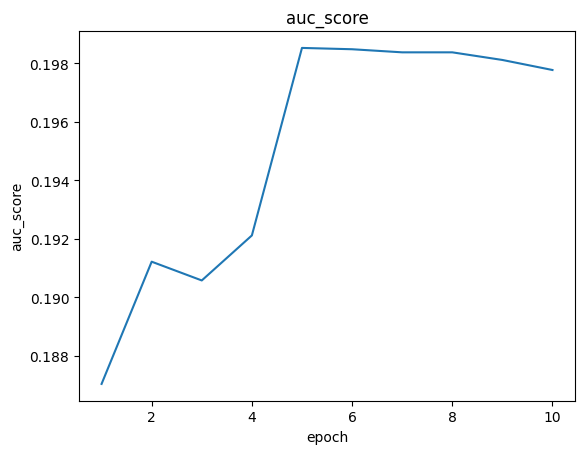

In [97]:
# acu_score曲线
plt.plot(list(range(1, epochs + 1)), auc_score_)
plt.title("auc_score")
plt.xlabel("epoch")
plt.ylabel("auc_score")
plt.show()